Step 4: Error Analysis
Quantitative and Qualitative Analysis of Model Errors

In [ ]:
# ADD THIS TO END OF STEP3 TO CREATE OOF FILES
# Calculate ensemble OOF
# ensemble_oof = w_blend * lex_best_oof + (1 - w_blend) * emb_best_oof

# # Save all three
# np.save('oof_predictions_lexical.npy', lex_best_oof)
# np.save('oof_predictions_ensemble.npy', ensemble_oof)

In [34]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, log_loss, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Load Data and Predictions

In [39]:
# Load training data
train_df = pd.read_csv('../data/train.csv')

# Reconstruct target labels
y_true = np.select(
    [train_df['winner_model_a'] == 1, 
     train_df['winner_model_b'] == 1, 
     train_df['winner_tie'] == 1], 
    [0, 1, 2]
)

# Load out-of-fold (OOF) predictions from Step 3 models
oof_baseline = np.load('oof_predictions_lexical.npy')  
oof_final = np.load('oof_predictions_ensemble.npy')      

# Define class labels
class_names = ['Model A', 'Model B', 'Tie']
classes = [0, 1, 2]

# Convert probabilities to hard predictions
y_pred_baseline = np.argmax(oof_baseline, axis=1)
y_pred_final = np.argmax(oof_final, axis=1)

Overall Performance Comparison

In [41]:
# Calculate log loss (competition metric) for each model
logloss_baseline = log_loss(y_true, oof_baseline)
logloss_final = log_loss(y_true, oof_final)

# Calculate accuracy
acc_baseline = (y_pred_baseline == y_true).mean()
acc_final = (y_pred_final == y_true).mean()

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Final Model'],
    'Log Loss': [logloss_baseline, logloss_final],
    'Accuracy': [acc_baseline, acc_final],
    'Error Rate': [1-acc_baseline, 1-acc_final]
})

print("OVERALL PERFORMANCE COMPARISON")
print("-"*70)
print(comparison_df.to_string(index=False))
print(f"\nImprovement: {(logloss_baseline - logloss_final):.4f} log loss reduction")
print(f"             {(acc_final - acc_baseline)*100:.2f}% accuracy gain")

OVERALL PERFORMANCE COMPARISON
----------------------------------------------------------------------
      Model  Log Loss  Accuracy  Error Rate
   Baseline  1.060626  0.445831    0.554169
Final Model  1.054110  0.455713    0.544287

Improvement: 0.0065 log loss reduction
             0.99% accuracy gain


Confusion Matrix Analysis

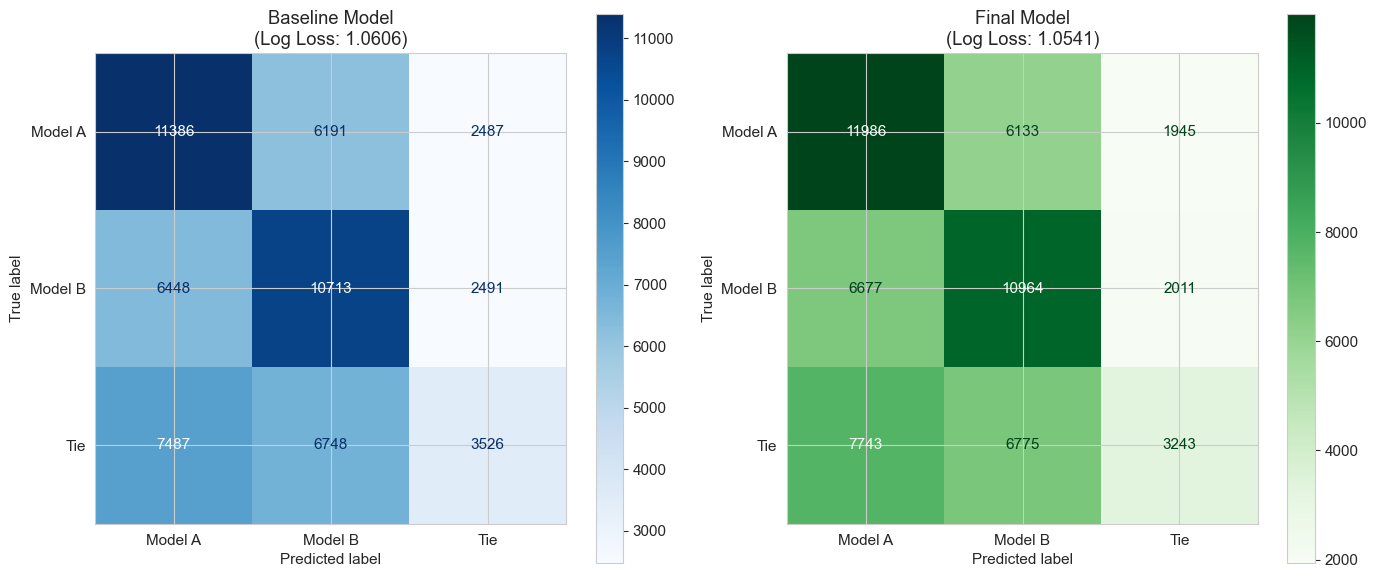


Confusion Matrix Interpretation:
- Diagonal: Correct predictions
- Off-diagonal: Misclassifications (true class → predicted class)


In [42]:
# Generate confusion matrices
cm_baseline = confusion_matrix(y_true, y_pred_baseline)
cm_final = confusion_matrix(y_true, y_pred_final)

# Visualize confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline model
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Baseline Model\n(Log Loss: {logloss_baseline:.4f})')

# Final model
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'Final Model\n(Log Loss: {logloss_final:.4f})')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix Interpretation:")
print("- Diagonal: Correct predictions")
print("- Off-diagonal: Misclassifications (true class → predicted class)")

Per-Class Performance Analysis

In [44]:
print("-"*70)
print("PER-CLASS PERFORMANCE - FINAL MODEL")
print("-"*70)

# Get detailed classification report
report = classification_report(y_true, y_pred_final, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(3))

# Calculate per-class log loss
print("\n" + "-"*70)
print("PER-CLASS LOG LOSS ANALYSIS")
print("-"*70)

for i, class_name in enumerate(class_names):
    mask = (y_true == i)
    if mask.sum() > 0:
        class_logloss = log_loss(y_true[mask], oof_final[mask], labels=classes)
        class_count = mask.sum()
        class_pct = (class_count / len(y_true)) * 100
        print(f"\n{class_name}:")
        print(f"  Samples: {class_count:,} ({class_pct:.1f}%)")
        print(f"  Log Loss: {class_logloss:.4f}")
        print(f"  Accuracy: {report[class_name]['precision']:.3f}")

----------------------------------------------------------------------
PER-CLASS PERFORMANCE - FINAL MODEL
----------------------------------------------------------------------
              precision  recall  f1-score    support
Model A           0.454   0.597     0.516  20064.000
Model B           0.459   0.558     0.504  19652.000
Tie               0.450   0.183     0.260  17761.000
accuracy          0.456   0.456     0.456      0.456
macro avg         0.455   0.446     0.427  57477.000
weighted avg      0.455   0.456     0.433  57477.000

----------------------------------------------------------------------
PER-CLASS LOG LOSS ANALYSIS
----------------------------------------------------------------------

Model A:
  Samples: 20,064 (34.9%)
  Log Loss: 1.0028
  Accuracy: 0.454

Model B:
  Samples: 19,652 (34.2%)
  Log Loss: 1.0196
  Accuracy: 0.459

Tie:
  Samples: 17,761 (30.9%)
  Log Loss: 1.1503
  Accuracy: 0.450


Qualitative Error Analysis

Examining specific examples of misclassifications to understand model weaknesses.

In [ ]:
# Qualitative Error Analysis - Find Worst Predictions

# Calculate prediction confidence (max probability)
confidence_baseline = np.max(oof_baseline, axis=1)
confidence_final = np.max(oof_final, axis=1)

# Find misclassified samples by final model
misclassified_mask = (y_pred_final != y_true)
misclassified_df = train_df[misclassified_mask].copy()
misclassified_df['true_label'] = y_true[misclassified_mask]
misclassified_df['pred_label'] = y_pred_final[misclassified_mask]
misclassified_df['confidence'] = confidence_final[misclassified_mask]
misclassified_df['true_class'] = misclassified_df['true_label'].map({0: 'Model A', 1: 'Model B', 2: 'Tie'})
misclassified_df['pred_class'] = misclassified_df['pred_label'].map({0: 'Model A', 1: 'Model B', 2: 'Tie'})

print(f"Total Misclassifications: {len(misclassified_df):,} ({len(misclassified_df)/len(train_df)*100:.1f}%)")

Total Misclassifications: 31,284 (54.4%)


In [54]:
# Sort by confidence to find high-confidence mistakes
high_conf_errors = misclassified_df.nlargest(10, 'confidence')

print("HIGH-CONFIDENCE ERRORS (Model was very wrong but very confident)")
print("-"*70)

for idx, row in high_conf_errors.head(3).iterrows():
    print(f"\n{'-'*70}")
    print(f"Example {idx}")
    print(f"True Winner: {row['true_class']} | Predicted: {row['pred_class']} | Confidence: {row['confidence']:.3f}")
    print(f"\nPrompt: {row['prompt'][:200]}...")
    print(f"\nResponse A: {row['response_a'][:200]}...")
    print(f"\nResponse B: {row['response_b'][:200]}...")
    print("-"*70)

HIGH-CONFIDENCE ERRORS (Model was very wrong but very confident)
----------------------------------------------------------------------

----------------------------------------------------------------------
Example 35603
True Winner: Tie | Predicted: Model A | Confidence: 0.740

Prompt: ["Give me some word that start with \"A\" and then calculate 7+23"]...

Response A: ["An apple a day keeps the doctor away.\n\nAardvark.\n\nAardwolf.\n\nAASP.\n\nAck-ack.\n\nAddress.\n\nAdder.\n\nAdivine.\n\nAeneas.\n\nAgave.\n\nAgent.\n\nAgitation.\n\nAgua.\n\nAhoy.\n\nAirport.\n\nA...

Response B: ["AAAAA"]...
----------------------------------------------------------------------

----------------------------------------------------------------------
Example 17181
True Winner: Model B | Predicted: Model A | Confidence: 0.705

Prompt: ["Ask me some yes or no questions to determine what hobby I would enjoy","no","yes","yes","yes","no","ni","no","yes"]...

Response A: ["Based on the search results, I ca

In [56]:
#Common Misclassification Patterns

print("MISCLASSIFICATION PATTERNS")
print("-"*70)

# Analyze confusion patterns
misclass_patterns = misclassified_df.groupby(['true_class', 'pred_class']).size().reset_index(name='count')
misclass_patterns = misclass_patterns.sort_values('count', ascending=False)

print("\nMost Common Confusion Pairs:")
print(misclass_patterns.head(10).to_string(index=False))

# Analyze by confidence levels
print("\n\nMisclassification by Confidence Level:")
bins = [0, 0.4, 0.6, 0.8, 1.0]
labels = ['Low (0-0.4)', 'Medium (0.4-0.6)', 'High (0.6-0.8)', 'Very High (0.8-1.0)']
misclassified_df['conf_bin'] = pd.cut(misclassified_df['confidence'], bins=bins, labels=labels)
print(misclassified_df['conf_bin'].value_counts().sort_index())

MISCLASSIFICATION PATTERNS
----------------------------------------------------------------------

Most Common Confusion Pairs:
true_class pred_class  count
       Tie    Model A   7743
       Tie    Model B   6775
   Model B    Model A   6677
   Model A    Model B   6133
   Model B        Tie   2011
   Model A        Tie   1945


Misclassification by Confidence Level:
conf_bin
Low (0-0.4)            17823
Medium (0.4-0.6)       13423
High (0.6-0.8)            38
Very High (0.8-1.0)        0
Name: count, dtype: int64
